# #WeRateDogs, An anaysis over tweets

### Table of contents

1. [Gathering](#gather_section)
2. [Assesment process](#assess_section)<br />
    2.1 [Quality Notes](#quality_notes)<br />
    2.2 [Tidiness Notes](#tidiness_notes)
3. [Cleaning](#cleaning_section)<br />
    3.1 [Get data tidy](#cleaning_tidiness)<br />
    3.2 [Get data clean](#cleaning_quality)
4. [Export data](#export_section)
5. [Analysis and Visualizations](#analysis_section)<br />
    5.1 [Ratings study](#ratings)<br />
    5.2 [Tweets media](#media)<br />
    5.3 [Favorite and Retweet count correlations](#correlations)<br />
    5.4 [Dog breeds](#dog_breeds)<br />
    5.5 [Doggos, puppers and other dog tags](#dog_tags)<br />
    

In [1]:
import json
import requests
import tweepy
import pandas as pd
import numpy as np
import os 

<a id="gather_section"></a>

## Gathering

##### Load provided twitter archive from #WeRateDogs

In [2]:
archive_df = pd.read_csv('twitter-archive-enhanced.csv')

##### Get Images Predictions file

In [3]:
result = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')
with open('image_predictions.tsv', mode='wb') as fp:
    fp.write(result.content)

In [4]:
predictions_df = pd.read_csv('image_predictions.tsv', sep='\t')
predictions_df.sample()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1503,784826020293709826,https://pbs.twimg.com/media/CuRDF-XWcAIZSer.jpg,1,chow,0.090341,True,binoculars,0.083499,False,Irish_setter,0.077456,True


##### Calling Tweeter API

In [5]:
consumer_key = 'YOUR CONSUMER KEY'
consumer_secret = 'YOUR CONSUMER SECRET'
access_token = 'YOUR ACCESS TOKEN'
access_secret = 'YOUR ACCESS SECRET'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth)

# Unfortunately, Twitter Dev portal has not replied to my application

_"We’ve received your application for a Twitter developer account, and we’re starting our review. Case# 0150166583 Twitter developer account application"_

In [6]:
# So, let's use file from Udacity ...
tweets_entries = []
with open('tweet-json-udacity.txt', mode='r', encoding='utf-8') as fd:
    json_string = fd.readline()
    while json_string != "":
        tweet_obj = json.loads(json_string)
        tweets_entries.append(tweet_obj)
        json_string = fd.readline()
api_tweets_df = pd.DataFrame(tweets_entries, columns=list(tweet_obj.keys()))

In [7]:
# Let's see the missing tweets in api file
archive_ids, api_ids = archive_df.tweet_id, api_tweets_df.id
list(set(archive_ids) - set(api_ids))

[771004394259247104, 888202515573088257]

In [8]:
archive_df.query("tweet_id in (771004394259247104, 888202515573088257)")

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Canela. She attempted s...,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,https://twitter.com/dog_rates/status/887473957...,13,10,Canela,None,None,None,None
815,771004394259247104,NaN,NaN,2016-08-31 15:19:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @katieornah: @dog_rates learning a lot at c...,7.710021e+17,1.732729e+09,2016-08-31 15:10:07 +0000,https://twitter.com/katieornah/status/77100213...,12,10,None,None,None,pupper,None


<a id="assess_section"></a>

## Assesment

_Let's assess WeRateDogs enhanced archive_

In [9]:
archive_df.sample(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1255,710609963652087808,NaN,NaN,2016-03-17 23:33:12 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",I've watched this a million times and you prob...,NaN,NaN,NaN,https://vine.co/v/idaTpwH5TgU,12,10,None,None,None,None,None
2082,670815497391357952,NaN,NaN,2015-11-29 04:04:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Sage. He likes to burn shit. 10/10 htt...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670815497...,10,10,Sage,None,None,None,None
540,806542213899489280,NaN,NaN,2016-12-07 16:53:43 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Waffles. He's concerned that the dandr...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/806542213...,11,10,Waffles,None,None,None,None


In [10]:
# Let´s try to find any duplicated entries
archive_df.tweet_id.duplicated().sum()

0

In [11]:
# Calculate how many missing tweet's links there are
archive_df.expanded_urls.isnull().sum()

59

In [12]:
# Visualize if rates correspond to tweet's text
archive_df.describe()[['rating_numerator' ,'rating_denominator']]
#We can see vast majority of numerators are between 10-14 and most of 
#denominators are 10, however there is at least 1 denominator as 0, which is invalid for our purposes

,rating_numerator,rating_denominator
count,2356.000000,2356.000000
mean,13.126486,10.455433
std,45.876648,6.745237
min,0.000000,0.000000
25%,10.000000,10.000000
50%,11.000000,10.000000
75%,12.000000,10.000000
max,1776.000000,170.000000


In [13]:
archive_df[archive_df['rating_denominator'] == 0]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,26259576.0,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None


In [14]:
# Check values for names
archive_df.name.value_counts()

None       745
a           55
Charlie     12
Lucy        11
Oliver      11
          ... 
Koko         1
Zooey        1
Tassy        1
Rose         1
Reagan       1
Name: name, Length: 957, dtype: int64

In [15]:
# Let´s discover some mistaken names
set(archive_df[archive_df.name.str.islower()]['name'])

{'a',
 'actually',
 'all',
 'an',
 'by',
 'getting',
 'his',
 'incredibly',
 'infuriating',
 'just',
 'life',
 'light',
 'mad',
 'my',
 'not',
 'officially',
 'old',
 'one',
 'quite',
 'space',
 'such',
 'the',
 'this',
 'unacceptable',
 'very'}

In [16]:
# Clearly there are 745 missing dog names on the data frame, however they 
# are marked as "None".
archive_df.name.isna().sum(), len(archive_df[archive_df.name == "None"])

(0, 745)

In [17]:
# Number of tweets with retweeted_status_id
archive_df.retweeted_status_id.notnull().sum()

181

In [18]:
# Number of tweets without rating
archive_df.rating_numerator.isna().sum() + archive_df.rating_denominator.isna().sum()

0

Assess data quality for tweets extracted from API.

_**Note**: For this data frame, we are only interested on retweet_count, favorite_count, reply_count, quote_count and extended_entities (to get media assets for each tweet)_

In [19]:
api_tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 27 columns):
created_at                       2354 non-null object
id                               2354 non-null int64
id_str                           2354 non-null object
full_text                        2354 non-null object
truncated                        2354 non-null bool
display_text_range               2354 non-null object
entities                         2354 non-null object
extended_entities                2073 non-null object
source                           2354 non-null object
in_reply_to_status_id            78 non-null float64
in_reply_to_status_id_str        78 non-null object
in_reply_to_user_id              78 non-null float64
in_reply_to_user_id_str          78 non-null object
in_reply_to_screen_name          78 non-null object
user                             2354 non-null object
geo                              0 non-null object
coordinates                      0 non-null

In [20]:
# No duplicates, that´s good
api_tweets_df.id.duplicated().sum()

0

In [21]:
api_tweets_df.extended_entities

0       {'media': [{'id': 892420639486877696, 'id_str'...
1       {'media': [{'id': 892177413194625024, 'id_str'...
2       {'media': [{'id': 891815175371796480, 'id_str'...
3       {'media': [{'id': 891689552724799489, 'id_str'...
4       {'media': [{'id': 891327551943041024, 'id_str'...
                              ...                        
2349    {'media': [{'id': 666049244999131136, 'id_str'...
2350    {'media': [{'id': 666044217047650304, 'id_str'...
2351    {'media': [{'id': 666033409081393153, 'id_str'...
2352    {'media': [{'id': 666029276303482880, 'id_str'...
2353    {'media': [{'id': 666020881337073664, 'id_str'...
Name: extended_entities, Length: 2354, dtype: object

_Assess data quality for predictions data frame_

In [22]:
predictions_df.sample(3)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
854,696488710901260288,https://pbs.twimg.com/media/CapsyfkWcAQ41uC.jpg,1,briard,0.369063,True,Scotch_terrier,0.168204,True,giant_schnauzer,0.120553,True
1727,820446719150292993,https://pbs.twimg.com/media/CxqsX-8XUAAEvjD.jpg,3,golden_retriever,0.938048,True,kuvasz,0.025119,True,Labrador_retriever,0.022977,True
795,690938899477221376,https://pbs.twimg.com/media/CZa1QnSWEAAEOVr.jpg,1,geyser,0.370318,False,seashore,0.274888,False,beacon,0.046397,False


In [23]:
# Looks like we don´t have any missing data here, however column names look poor descriptive
predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [24]:
# By sampling a little bit, we can see that tag names are sometimes capitalized, sometimes lowercase
predictions_df.sample(3)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1831,836380477523124226,https://pbs.twimg.com/media/C5trm6iWgAQ22Hw.jpg,1,wooden_spoon,0.082489,False,sliding_door,0.061017,False,grand_piano,0.055086,False
39,666649482315059201,https://pbs.twimg.com/media/CUBqKnLWwAA5OQB.jpg,1,Border_collie,0.447803,True,English_springer,0.170497,True,collie,0.139206,True
360,672640509974827008,https://pbs.twimg.com/media/CVWy9v-VAAALSoE.jpg,1,Chesapeake_Bay_retriever,0.420155,True,Cardigan,0.266030,True,Labrador_retriever,0.042514,True


In [25]:
# We can see all probability values are valid (any value between 0 and 1)
predictions_df.describe()[['p1_conf', 'p2_conf', 'p3_conf']]

,p1_conf,p2_conf,p3_conf
count,2075.000000,2.075000e+03,2.075000e+03
mean,0.594548,1.345886e-01,6.032417e-02
std,0.271174,1.006657e-01,5.090593e-02
min,0.044333,1.011300e-08,1.740170e-10
25%,0.364412,5.388625e-02,1.622240e-02
50%,0.588230,1.181810e-01,4.944380e-02
75%,0.843855,1.955655e-01,9.180755e-02
max,1.000000,4.880140e-01,2.734190e-01


<a id="quality_notes"></a>

### Quality Notes

##### `twitter-archive-enhanced` data frame
- Data frame contains some some non original tweets (observations with a non-null `retweeted_status_id`) 
- 59 Missing `expanded_urls` for tweets
- A bunch of tweets have invalid numerators (for example tweet 883482846933004288, captured value is 5 instead of 13.5).
- Invalid denominator zero (tweet 835246439529840640)
- Invaild rate for tweet 666287406224695296, it should be 9/10
- `timestamp` data type is string instead datetime
- Mistaken captured dog names (such as "a", "an", "by" etc ...)
- Standarize "None" values for missing dog names as NaN 

##### `predictions` data frame
- Consistency issue: Standarize tag values by lowercasing all of them.

<a id="tidiness_notes"></a>

### Tidiness Notes

- For simplicity on all data frames, let´s assign `tweet_id` as the index and convert it to string (we are not going to perform mathematical operations over tweet id's)

##### `twitter-archive-enhanced` data frame
- Dog stage should be concentrated in just one column `dog_stage` with categorical value from (doggo, floofer, pupper, puppo, None)
- There should be only 1 dataset with tweet information. Blend tweets from archive, from API and predictions into a single dataframe
- Create a column that condenses rating information:  `rating_numerator` / `rating_denominator`

##### `twitter-api` data frame
- Rename `id` as `tweet_id`. This is the standard name used in the rest of datafarmes
- For each tweet, extract `tweet_id` and from `extended_media`, pull out `media_url`, `type` and order in the array. Create a new entry with those values in a `media_assets` data frame. 

##### `predictions` data frame
- Give more friendly name to columns (p1 -> tag1, p1_conf -> tag1_probability, p1_dog tag1_is_dog)


<a id="cleaning_section"></a>

## Cleaning

It is generally best to tackle tidy issues first, then quality issues next, as it´s easier to clean up dirty data in a well strutured framework. So we are going to start working on Tidiness points above first

In [26]:
archive_df_clean = archive_df.copy()
api_tweets_df_clean = api_tweets_df.copy()
predictions_df_clean = predictions_df.copy()

<a id="cleaning_tidiness"></a>

### Tidiness

##### Define
For api tweets data frame, rename id as `tweet_id`. This is the standard name used in the rest of datafarmes

##### Code

In [27]:
api_tweets_df_clean.rename(columns={'id':'tweet_id'}, inplace=True)

##### Test

In [28]:
assert "tweet_id" in api_tweets_df_clean.columns.to_list()

##### Define

Reindex all dataframes to their `tweet_id` values

##### Code

In [29]:
# set tweet_id as our index in all data frames
archive_df_clean.set_index('tweet_id', inplace=True)
api_tweets_df_clean.set_index('tweet_id', inplace=True)
predictions_df_clean.set_index('tweet_id', inplace=True)

In [30]:
# Then change types to string
archive_df_clean.index = archive_df_clean.index.astype(str)
api_tweets_df_clean.index = api_tweets_df_clean.index.astype(str)
predictions_df_clean.index = predictions_df_clean.index.astype(str)

##### Test

In [31]:
assert archive_df_clean.index.name == 'tweet_id'
assert archive_df_clean.index.dtype == np.dtype(np.object)
assert api_tweets_df_clean.index.name == 'tweet_id'
assert api_tweets_df_clean.index.dtype == np.dtype(np.object)
assert predictions_df_clean.index.name == 'tweet_id'
assert predictions_df_clean.index.dtype == np.dtype(np.object)

##### Define
Pull out media entries from `extended_media`,
For each entry, extract `media_url`, `type` and order in the array,then create a new entry with those values in a `media_assets` data frame. 

##### Code

In [32]:
media_entries = []
media_json_df = api_tweets_df_clean[api_tweets_df_clean.extended_entities.notna()][['extended_entities']]

for row in media_json_df.itertuples():
    tweet_id = row[0]
    media_list = row[1]['media']
    asset_index = 1
    for asset in media_list:

        media_entries.append({'tweet_id' : tweet_id, 'media_url': asset['media_url'], 'type' : asset['type'], 'expanded_url' : asset['expanded_url'], 'asset_number' : asset_index})
        asset_index += 1

media_assets_df = pd.DataFrame(media_entries, columns=['tweet_id', 'media_url', 'type', 'expanded_url', 'asset_number'])

##### Test

In [33]:
media_assets_df.sample(4)

,tweet_id,media_url,type,expanded_url,asset_number
2546,673240798075449344,http://pbs.twimg.com/media/CVfU7KLXAAAAgIa.jpg,photo,https://twitter.com/dog_rates/status/673240798...,1
1036,779123168116150273,http://pbs.twimg.com/media/CtAAYizW8AAWzBZ.jpg,photo,https://twitter.com/dog_rates/status/779123168...,1
1900,699801817392291840,http://pbs.twimg.com/media/CbYyCMcWIAAHHjF.jpg,photo,https://twitter.com/dog_rates/status/699801817...,2
304,849412302885593088,http://pbs.twimg.com/media/C8m3-hmWsAUmhkK.jpg,photo,https://twitter.com/dog_rates/status/849412302...,3


##### Define
There should be only 1 data frame with tweet information. 
Gather additional columns of interest from api tweets data frame (retweet_count, favorite_count, extended_entities) as well as predictions into a tweet archive dataframe using `tweet_id` as the common column.

##### Code

In [34]:
archive_df_clean = pd.merge(archive_df_clean, api_tweets_df_clean[['retweet_count', 'favorite_count']], how="left", on=["tweet_id"])

In [35]:
archive_df_clean = pd.merge(archive_df_clean, predictions_df_clean, how="left", on=["tweet_id"])

##### Test

In [36]:
assert "retweet_count" in archive_df_clean.columns.to_list()
assert "favorite_count" in archive_df_clean.columns.to_list()

In [37]:
archive_df_clean.columns

Index(['in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp', 'source',
       'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'retweet_count', 'favorite_count', 'jpg_url', 'img_num', 'p1',
       'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf',
       'p3_dog'],
      dtype='object')

##### Define
During import process, `retweet_count` and `favorite_count` got converted to float (because there are couple of tweets with this missing data). Assign missing values for mentioned couple columsn to zero then convert them back to int type.

##### Code

In [38]:
archive_df_clean.loc[archive_df_clean.retweet_count.isna(), 'retweet_count'] = 0
archive_df_clean.loc[archive_df_clean.favorite_count.isna(), 'favorite_count'] = 0

In [39]:
archive_df_clean.retweet_count = archive_df_clean.retweet_count.astype(np.int32)
archive_df_clean.favorite_count = archive_df_clean.favorite_count.astype(np.int32)

##### Test

In [40]:
assert archive_df_clean.retweet_count.dtype == np.dtype('int32')
assert archive_df_clean.favorite_count.dtype == np.dtype('int32')

##### Define
Concatenate values from columns doggo, floofer, pupper and puppo, then assign concatenation string into a single column called `dog_stage`. Finally, remove previous 4 mentioned columns, we don´t need them anymore.

##### Code

In [41]:
# Concatenate values 
archive_df_clean['dog_stage'] = archive_df_clean['doggo'] + " " + archive_df_clean['floofer'] + " " + archive_df_clean['pupper'] + " " + archive_df_clean['puppo']
# Then process string concatenation 
archive_df_clean['dog_stage'] = archive_df_clean['dog_stage'].str.replace("None", "")
archive_df_clean['dog_stage'] = archive_df_clean['dog_stage'].str.strip()
archive_df_clean['dog_stage'] = archive_df_clean['dog_stage'].str.replace(r'\s+',', ')

In [42]:
# replace all empty values by np.NaN
archive_df_clean.loc[archive_df_clean.dog_stage == '', 'dog_stage'] = np.NAN

In [43]:
archive_df_clean.drop(columns=['doggo', 'floofer', 'pupper', 'puppo'], axis=1, inplace=True)

##### Test

In [44]:
# Verify available values for dog_stage 
archive_df_clean.dog_stage.value_counts()

pupper            245
doggo              83
puppo              29
doggo, pupper      12
floofer             9
doggo, floofer      1
doggo, puppo        1
Name: dog_stage, dtype: int64

In [45]:
# Make sure all other columns are no longer part of data frame
column_names = list(archive_df_clean)
assert "doggo" not in column_names
assert "floofer" not in column_names
assert "pupper" not in column_names
assert "puppo" not in column_names

##### Define

Create a column that condenses rating information: rating_numerator / rating_denominator

##### Code

In [46]:
archive_df_clean['rating'] = archive_df_clean.rating_numerator / archive_df_clean.rating_denominator

##### Test

In [47]:
# We can detect there is one 'infinite value', this is because it is an entry 
# with invalid rating_denominator = 0, we are going to address that dirty data later.
archive_df_clean.rating.value_counts().sort_index(ascending=False)

inf             1
177.600000      1
66.600000       1
42.000000       2
18.200000       1
7.500000        2
3.428571        1
2.700000        1
2.600000        1
1.700000        1
1.500000        2
1.400000       54
1.300000      351
1.250000        1
1.200000      562
1.100000      469
1.000000      463
0.900000      157
0.818182        2
0.800000      102
0.733333        1
0.700000       54
0.636364        1
0.600000       32
0.500000       38
0.400000       15
0.300000       19
0.200000       11
0.100000        8
0.000000        2
Name: rating, dtype: int64

##### Define

Give prediction columns more meaningful names (p1 -> tag1, p1_conf -> tag1_probability, p1_dog tag1_is_dog)

##### Code

In [48]:
archive_df_clean.rename(columns={'p1' : 'tag1', 'p1_conf' : 'tag1_probability', 'p1_dog' : 'tag1_is_dog','p2' : 'tag2', 'p2_conf' : 'tag2_probability', 'p2_dog' : 'tag2_is_dog', 'p3' : 'tag3', 'p3_conf' : 'tag3_probability', 'p3_dog' : 'tag3_is_dog'}, inplace=True)

##### Test

In [49]:
archive_df_clean.columns

Index(['in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp', 'source',
       'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'retweet_count', 'favorite_count',
       'jpg_url', 'img_num', 'tag1', 'tag1_probability', 'tag1_is_dog', 'tag2',
       'tag2_probability', 'tag2_is_dog', 'tag3', 'tag3_probability',
       'tag3_is_dog', 'dog_stage', 'rating'],
      dtype='object')

<a id="cleaning_quality"></a>

### Data quality

##### Define

- Before start cleaning dirty data in archive data frame, we might want to get rid of observations that does not meet our specifications. Indeed, data frame contains some retweets .We want original tweets only. Filter all entries with non-null `retweeted_status_id`


##### Code

In [50]:
archive_df_clean = archive_df_clean[archive_df_clean.retweeted_status_id.isnull()]

##### Test

In [51]:
assert archive_df_clean.retweeted_status_id.notnull().sum() == 0

##### Define

- `expanded_urls` it´s an important data piece for a tweet. It is actually tweet´s url. Verify if this information is present on other dataframes so we can fill those missing urls in archive data frame.

##### Code

In [52]:
# tweet id´s for those tweets without url
missing_urls_index = archive_df_clean[archive_df_clean.expanded_urls.isna()].index
missing_urls_index

Index(['886267009285017600', '881633300179243008', '879674319642796034',
       '870726314365509632', '863427515083354112', '857214891891077121',
       '856288084350160898', '855862651834028034', '855860136149123072',
       '850333567704068097', '848213670039564288', '847617282490613760',
       '840698636975636481', '838150277551247360', '838085839343206401',
       '835246439529840640', '832088576586297345', '831926988323639298',
       '828361771580813312', '826598799820865537', '823333489516937216',
       '821153421864615936', '813130366689148928', '811647686436880384',
       '801854953262350336', '800859414831898624', '797165961484890113',
       '786051337297522688', '785515384317313025', '766714921925144576',
       '763956972077010945', '750381685133418496', '747651430853525504',
       '738891149612572673', '707983188426153984', '704491224099647488',
       '696518437233913856', '696490539101908992', '693644216740769793',
       '693582294167244802', '692423280028966913', 

In [53]:
api_tweets_df_clean.loc[missing_urls_index, 'extended_entities']

tweet_id
886267009285017600    NaN
881633300179243008    NaN
879674319642796034    NaN
870726314365509632    NaN
863427515083354112    NaN
857214891891077121    NaN
856288084350160898    NaN
855862651834028034    NaN
855860136149123072    NaN
850333567704068097    NaN
848213670039564288    NaN
847617282490613760    NaN
840698636975636481    NaN
838150277551247360    NaN
838085839343206401    NaN
835246439529840640    NaN
832088576586297345    NaN
831926988323639298    NaN
828361771580813312    NaN
826598799820865537    NaN
823333489516937216    NaN
821153421864615936    NaN
813130366689148928    NaN
811647686436880384    NaN
801854953262350336    NaN
800859414831898624    NaN
797165961484890113    NaN
786051337297522688    NaN
785515384317313025    NaN
766714921925144576    NaN
763956972077010945    NaN
750381685133418496    NaN
747651430853525504    NaN
738891149612572673    NaN
707983188426153984    NaN
704491224099647488    NaN
696518437233913856    NaN
696490539101908992    NaN
693

Unfortunately, none of those tweets have `media` data. Despite of this fact, I decided to keep those 59 tweets as a missing tweet url might not be so impactful for future analyses performed upon this data set. In fact, those tweets provide other valuable information such as ratings, retweet and favorite counts ...

In [54]:
archive_df_clean.loc[missing_urls_index, ['retweet_count', 'favorite_count', 'rating']]

,retweet_count,favorite_count,rating
tweet_id,,,
886267009285017600,4,117,1.200000
881633300179243008,7,129,1.700000
879674319642796034,10,315,1.400000
870726314365509632,3,121,1.000000
863427515083354112,105,2363,1.200000
857214891891077121,20,242,1.200000
856288084350160898,17,545,1.400000
855862651834028034,27,320,42.000000
855860136149123072,1058,4407,66.600000


##### Define

- Tweet 835246439529840640 contains an invalid rate because of its zero denominator. That´s also mentioned in the tweet text itself: _"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho"_. Remove this tweet from dataframe


##### Code

In [55]:
archive_df_clean.shape

(2175, 27)

In [56]:
# Let's try to drop that tweet
try:
    archive_df_clean.drop(index=['835246439529840640'], inplace=True)
except KeyError:
    print('tweet 835246439529840640 already dropped')

##### Test

In [57]:
try:
    archive_df_clean.loc['835246439529840640']
    assert False
except KeyError:
    print("tweet not found")
    assert True

tweet not found


##### Define

- Using regular expression \d+.\d*\/\d+, Capture all tweets that contain ratings in the form of e.g. 4/10, 12/10 or 13.5/10 and extract this rating. Then use str.split('/') to get numerators and denominators. Finally set those pairs of extracted numbers to numerator and denominator for data frame

##### Code

In [58]:
tweets_with_rank = archive_df_clean[archive_df_clean.text.str.contains(r"(\d+.\d*\/\d+)")][['text', 'rating_numerator']]

/Users/iramos@tiempodevelopment.com/opt/anaconda3/lib/python3.7/site-packages/pandas/core/strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [59]:
# Extract correct rating
ranks = tweets_with_rank.text.str.extract(r'(\d+\.?\d+\/\d+)', expand=False)

In [60]:
# then split numerator and denominator
ranks = ranks.str.split('/', expand=True)

In [61]:
# Assign correct numerators and denominators to tweets
for row in ranks.itertuples():
    archive_df_clean.loc[row[0], 'rating_numerator'] = row[1]
    archive_df_clean.loc[row[0], 'rating_denominator'] = row[2]

In [62]:
archive_df_clean.rating_numerator = archive_df_clean.rating_numerator.astype(np.float)
archive_df_clean.rating_denominator = archive_df_clean.rating_denominator.astype(np.float)
archive_df_clean['rating'] = archive_df_clean.rating_numerator / archive_df_clean.rating_denominator

##### Test

In [63]:
assert archive_df_clean.loc['883482846933004288', 'rating_numerator'] == 13.5
assert archive_df_clean.loc['883482846933004288', 'rating'] == 1.35

In [64]:
archive_df_clean.rating.value_counts()

1.200000      504
1.000000      446
1.100000      432
1.300000      309
0.900000      156
0.800000       97
0.700000       53
1.400000       44
0.500000       33
0.600000       32
0.300000       19
0.400000       14
0.200000       10
0.100000        7
0.000000        2
42.000000       2
1.126000        1
1.127000        1
0.733333        1
18.200000       1
1.350000        1
0.975000        1
66.600000       1
1.700000        1
0.950000        1
1.250000        1
3.428571        1
1.500000        1
177.600000      1
Name: rating, dtype: int64

##### Define

- Invaild rate for tweet 666287406224695296, it should be 9/10. _"This is an Albanian 3 1/2 legged  Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv"_

##### Code

In [65]:
archive_df_clean.loc['666287406224695296', 'rating_numerator'] = 9
archive_df_clean.loc['666287406224695296', 'rating_denominator'] = 10
archive_df_clean.loc['666287406224695296', 'rating'] = 9/10

##### Test

In [66]:
assert archive_df_clean.loc['666287406224695296', 'rating_numerator'] == 9
assert archive_df_clean.loc['666287406224695296', 'rating_denominator'] == 10
assert archive_df_clean.loc['666287406224695296', 'rating'] == 0.9

##### Define

- Change `timestamp` data type in archive data frame from string to datetime. This will help to do further analysis operations over dates

##### Code

In [67]:
archive_df_clean.timestamp = archive_df_clean.timestamp.astype(np.dtype('<M8[ns]'))

##### Test

In [68]:
assert archive_df_clean.timestamp.dtype == np.dtype('<M8[ns]')

##### Define

- A bunch of Dog names are improperly parsed (such as "a", "an", "by" etc ...)
    1. Assign NaN to "None" names
    2. Assign NaN to non-capitalized names

##### Code

In [69]:
archive_df_clean.loc[archive_df_clean.name.str.islower(), 'name'] = np.nan

##### Test

In [70]:
assert archive_df_clean.name.str.islower().sum() == 0

##### Define

- Standarize "None" values for missing dog names as NaN 

##### Code

In [71]:
none_names_index = archive_df_clean[archive_df_clean.name == 'None'].index
archive_df_clean.loc[none_names_index, 'name'] = np.nan

##### Test

In [72]:
assert archive_df_clean[archive_df_clean.name == "None"].shape[0] == 0

##### Define


- Consistency issue: For predictions columns, standarize tag values by lowercasing all of them.

##### Code

In [73]:
archive_df_clean['tag1'] = archive_df_clean.tag1.str.lower()
archive_df_clean['tag2'] = archive_df_clean.tag2.str.lower()
archive_df_clean['tag3'] = archive_df_clean.tag3.str.lower()

##### Test

In [74]:
assert all(archive_df_clean.tag1.str.islower())
assert all(archive_df_clean.tag2.str.islower())
assert all(archive_df_clean.tag3.str.islower())

In [75]:
archive_df_clean.sample(3)[['tag1', 'tag2', 'tag3']]

,tag1,tag2,tag3
tweet_id,,,
672997845381865473,chow,pomeranian,koala
883482846933004288,golden_retriever,labrador_retriever,kuvasz
832682457690300417,NaN,NaN,NaN


<a id="export_section"></a>

## Export data

After our data wrangling process, our final step is to export our tiddy clean data into csv files as well as SQL db file in case other researches want to work with persisted data.

In [76]:
#We also want indexes to be saved, as those represent tweet id´s
archive_df_clean.to_csv('twitter_archive_master.csv', index=True)
# In this case, we have a generic consecutive index for assets, so we don´t want that info.
media_assets_df.to_csv('media_assets_master.csv', index=False)

In [77]:
from sqlalchemy import create_engine

In [78]:
engine = create_engine('sqlite:///weratedogs.db')

In [79]:
archive_df_clean.to_sql('tweet_archive', engine, index=True)
media_assets_df.to_sql('tweet_media', engine, index=False)

<a id="analysis_section"></a>

## Analyze and Visualize

In [80]:
tweets = pd.read_csv('twitter_archive_master.csv')
media = pd.read_csv('media_assets_master.csv')

Now, let´s explore our cleaned data to discover common patterns and see data shape

In [81]:
import matplotlib.pyplot as plt
import math

%matplotlib inline

<a id="ratings"></a>

**Q1:  WeRateDogs have a non-common way to rank dog pictures. How are those ratings distributed along the tweet history?**


In [82]:
rating_counts = tweets.rating.value_counts()
rating_counts

1.200000      504
1.000000      446
1.100000      432
1.300000      309
0.900000      157
0.800000       97
0.700000       53
1.400000       44
0.500000       33
0.600000       32
0.300000       19
0.400000       14
0.200000       10
0.100000        7
0.000000        2
42.000000       2
1.126000        1
1.127000        1
0.733333        1
18.200000       1
1.350000        1
0.975000        1
66.600000       1
1.700000        1
0.950000        1
1.250000        1
3.428571        1
1.500000        1
177.600000      1
Name: rating, dtype: int64

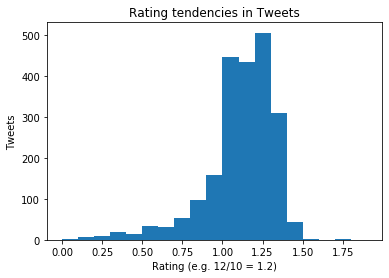

In [83]:
# Vast majority of ratings concentrate between 0 - 1.4, so let´s set bins as 0, 0.1 , 0.2 ... 1.4
rating_bins = [x / 10 for x in range(0, 20)]
#rating_counts.plot.hist('rating', bins=rating_bins)
data = tweets.rating
plt.hist(data, bins=rating_bins);
plt.xlabel("Rating (e.g. 12/10 = 1.2)");
plt.ylabel("Tweets");
plt.title("Rating tendencies in Tweets");

<a id="media"></a>

**Q2: How people tend to share media in their tweets?**

In [84]:
media_totals = media.groupby('type').count()
# We can appreciate that vast majority tend to use pictures, a little videos and very few gifs

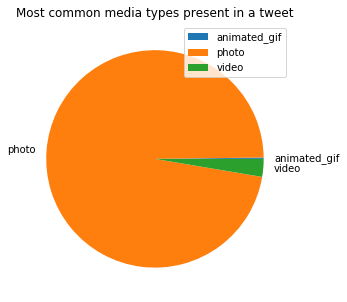

In [85]:
media_totals.plot.pie(y='tweet_id', figsize=(5,5));
plt.title("Most common media types present in a tweet");
plt.ylabel("");

<a id="correlations"></a>

**Q3: Can we see a pattern of correlation between favorite count and the fact is retweeted? How about between favorite count and given rating?**

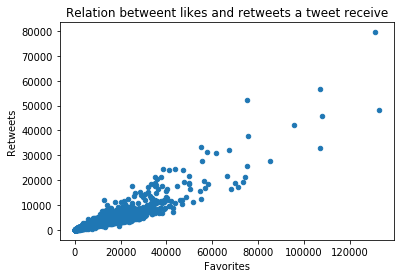

In [86]:
tweets.plot.scatter('favorite_count', 'retweet_count');
plt.title("Relation betweent likes and retweets a tweet receive");
plt.ylabel("Retweets");
plt.xlabel("Favorites");

Apparently, there is a tendency of retweet a favorited tweet.

In [87]:
tweets.rating.describe()

count    2174.000000
mean        1.221499
std         4.245155
min         0.000000
25%         1.000000
50%         1.100000
75%         1.200000
max       177.600000
Name: rating, dtype: float64

From above description we can see there are clearly some outliers in our ratings as 75% of population is between 0 and 1.2, then suddently goes to a max value of 177.6
Let's limit ratings to take the ones betweet 0 - 2.

In [88]:
no_outlier_ratings = tweets[tweets.rating <= 2]

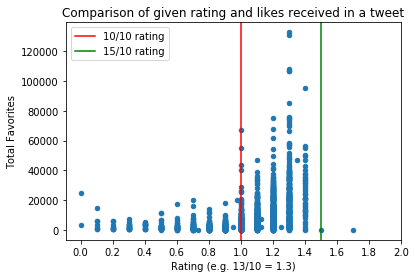

In [89]:
ax = no_outlier_ratings.plot.scatter('rating', 'favorite_count');
plt.axvline(x=1.0, c='r', label="10/10 rating");
plt.axvline(x=1.5, c='g', label="15/10 rating");
plt.title("Comparison of given rating and likes received in a tweet")
plt.xlabel('Rating (e.g. 13/10 = 1.3)');
plt.ylabel('Total Favorites');
ax.set_xticks([(x / 10) * 2 for x in range(0, 11)], minor=False)
plt.legend();

From above graphic, looks like more famous tweets are associated with a rating betweet 10/10 and 15/10. For those outliers with not so common rating above 15/10, looks like are not impacted by a high favorite count

<a id="dog_breeds"></a>

**Q4: What are the top 20 dog breeds appearing in WeRateDogs?**

In [90]:
# Lets consider only first tag as it is the one with highest probability and filter by dog
predictions = tweets[tweets.tag1_is_dog == True]
# then the top 20 breeds
top_breeds = predictions.tag1.value_counts()[:20]
top_breeds = top_breeds.sort_values()

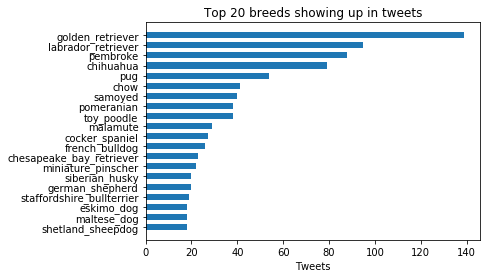

In [91]:
plt.barh(top_breeds.index, top_breeds.values, height=0.6, align='center');
plt.xlabel("Tweets");
plt.title("Top 20 breeds showing up in tweets");

<a id="dog_tags"></a>

**Q5: What are the most common tags for pets?**

In [92]:
dog_tags = tweets[tweets.dog_stage.notna()]

In [93]:
tag_count = dog_tags.dog_stage.value_counts()
tag_count

pupper            224
doggo              75
puppo              24
doggo, pupper      10
floofer             9
doggo, floofer      1
doggo, puppo        1
Name: dog_stage, dtype: int64

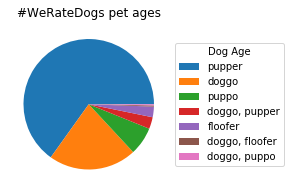

In [94]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))

data = tag_count.values
stages = tag_count.index.to_list()


wedges, autotexts = ax.pie(data, textprops=dict(color="w"))

ax.legend(wedges, stages,
          title="Dog Age",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=8, weight="bold")

ax.set_title("#WeRateDogs pet ages")

plt.show()